# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

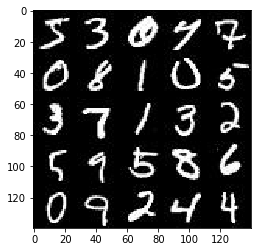

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

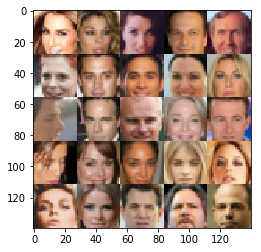

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Applications/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [49]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name='input_real')
    input_z = tf.placeholder(tf.float32,[None,z_dim],name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return input_real,input_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [70]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    stddev = 0.02
    alpha = 0.2
    
    with tf.variable_scope('discriminator',reuse=reuse):
        hidden_1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',
                                   kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        hidden_1 = tf.maximum(alpha*hidden_1,hidden_1)
        # 14*14*64 now
        
        hidden_2 = tf.layers.conv2d(hidden_1,128,5,strides=2,padding='same',
                                   kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        hidden_2 = tf.layers.batch_normalization(hidden_2,training=True)
        hidden_2 = tf.maximum(alpha*hidden_2,hidden_2)
        # 7*7*128 now
        
        # Flatten it
        flat = tf.reshape(hidden_2,(-1,7*7*128))
        
        # Fully connected layer
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
    
    return logits,output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [71]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    stddev = 0.02
    alpha = 0.2
    
    with tf.variable_scope('generator',reuse=not is_train):
        # Fully connected layer
        hidden_1 = tf.layers.dense(z,7*7*512)
        # Reshape hidden_1
        hidden_1 = tf.reshape(hidden_1,(-1,7,7,512))
        # Apply batch normalization
        hidden_1 = tf.layers.batch_normalization(hidden_1,training=is_train)
        # Leaky RELU
        hidden_1 = tf.maximum(alpha*hidden_1,hidden_1)
        # 7*7*512 now
        
        hidden_2 = tf.layers.conv2d_transpose(hidden_1,256,5,strides=2,padding='same',
                                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        hidden_2 = tf.layers.batch_normalization(hidden_2,training=is_train)
        hidden_2 = tf.maximum(alpha*hidden_2,hidden_2)
        # 14*14*256 now
        
        logits = tf.layers.conv2d_transpose(hidden_2,out_channel_dim,5,strides=2,padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # 28*28*out_channel_dim now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [72]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z,out_channel_dim)
    d_logits_real,output = discriminator(input_real)
    d_logits_fake,output = discriminator(g_out,reuse=True)
    
    # Generate labels
    label_ones = tf.ones_like(d_logits_real)
    label_zeros = tf.zeros_like(d_logits_fake)
    
    # Calculate the losses
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=label_ones))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=label_ones*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=label_zeros))
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [73]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Separate generator and discriminator variables
    var_t = tf.trainable_variables()
    var_g = [var for var in var_t if var.name.startswith('generator')]
    var_d = [var for var in var_t if var.name.startswith('discriminator')]
    
    # Optimization
    train_opt_g = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,
                                                                                          var_list=var_g)
    train_opt_d = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,
                                                                                          var_list=var_d)
    
    return train_opt_g,train_opt_d


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [75]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param lr: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    elif data_image_mode == 'L':
        out_channel_dim = 1
    
    input_real,input_z,learning_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss = model_loss(input_real,input_z,out_channel_dim)
    train_opt_g,train_opt_d = model_opt(d_loss,g_loss,learning_rate,beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1
                # Create input_z for the generator
                batch_z = np.random.uniform(-1,1,[batch_size,z_dim])
                
                _ = sess.run(train_opt_g,feed_dict={input_real:batch_images,input_z:batch_z,
                                                    learning_rate:lr})
                _ = sess.run(train_opt_d,feed_dict={input_real:batch_images,input_z:batch_z,
                                                    learning_rate:lr})
                
                # Print intermediate losses
                if steps%10 == 0:
                    train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,input_z:batch_z})
                    train_loss_g = sess.run(g_loss,feed_dict={input_real:batch_images,input_z:batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                # Print intermediate figures
                if steps%100 == 0:
                    show_generator_output(sess,25,input_z,out_channel_dim,data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 25.2876
Epoch 1/2... Discriminator Loss: 0.3660... Generator Loss: 8.9283
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 23.1861
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 11.3497
Epoch 1/2... Discriminator Loss: 0.3596... Generator Loss: 7.5060
Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 6.4887
Epoch 1/2... Discriminator Loss: 5.5157... Generator Loss: 8.3254
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 4.1392
Epoch 1/2... Discriminator Loss: 0.7428... Generator Loss: 3.1308
Epoch 1/2... Discriminator Loss: 2.6926... Generator Loss: 7.4954


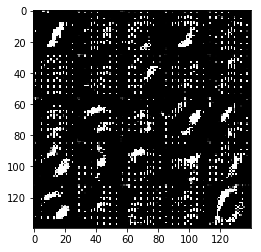

Epoch 1/2... Discriminator Loss: 2.1811... Generator Loss: 5.5900
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 4.3080
Epoch 1/2... Discriminator Loss: 2.0638... Generator Loss: 5.2298
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 1.0957
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 1.6141
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.8769
Epoch 1/2... Discriminator Loss: 0.7128... Generator Loss: 3.1271
Epoch 1/2... Discriminator Loss: 0.7272... Generator Loss: 2.1335


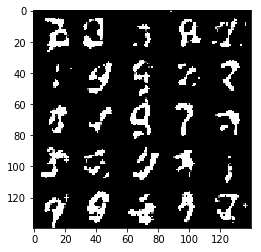

Epoch 1/2... Discriminator Loss: 1.8630... Generator Loss: 4.8565
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.9331
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 3.7157
Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 1.4957
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 1.5990
Epoch 1/2... Discriminator Loss: 1.6130... Generator Loss: 2.9027
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 2.3555
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 2.3339
Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 0.9161


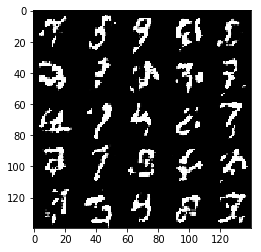

Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 1.3564
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.8506
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 2.0060
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 1.1596
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 2.2079
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 1.3620
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.5171


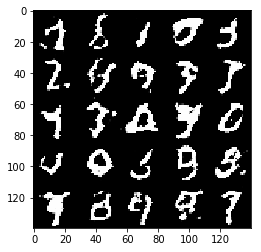

Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 2.5488
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 2.4903
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 1.5676
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 1.3904
Epoch 2/2... Discriminator Loss: 1.4852... Generator Loss: 2.0586
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 1.1348
Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 1.8675


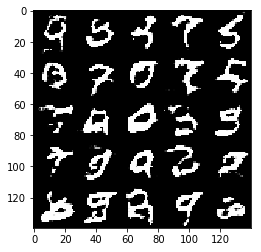

Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 1.3025
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 1.0846... Generator Loss: 1.2962
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 1.4848
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 1.4422
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 1.5321
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 0.7396


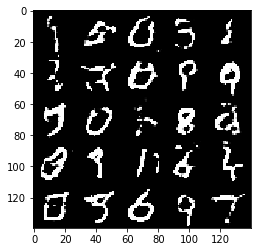

Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 1.2005
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.0813
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 1.2371
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.8990
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 1.8423
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 1.6336
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.9998


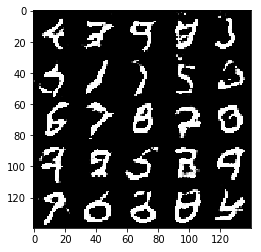

Epoch 2/2... Discriminator Loss: 1.1040... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 1.3241
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 1.4225
Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 1.8818
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 1.1832... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 1.2295... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 1.2573


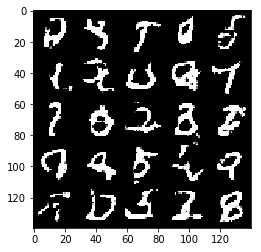

Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 1.0056
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 1.5805
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 1.3886
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 1.8537
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 1.2975
Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 1.3128
Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 1.4239


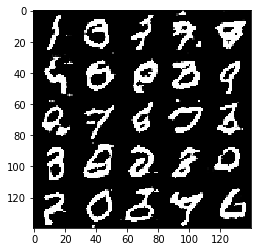

Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 1.4343
Epoch 2/2... Discriminator Loss: 1.0385... Generator Loss: 1.2754


In [76]:
batch_size = 128
z_dim = 100
lr = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, lr, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 15.2611
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 7.4453
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 3.9838
Epoch 1/1... Discriminator Loss: 1.9256... Generator Loss: 12.3397
Epoch 1/1... Discriminator Loss: 1.9869... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 3.9616
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 4.6136
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 2.3492
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.9692
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 6.3283


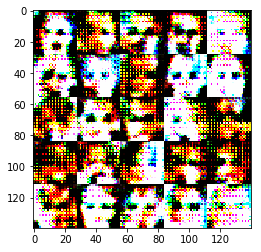

Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 9.9770
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 5.4883
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 5.5304
Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 5.0302
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 5.2936
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 5.1134
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 5.3963
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 7.0527
Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 5.7928
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 5.4012


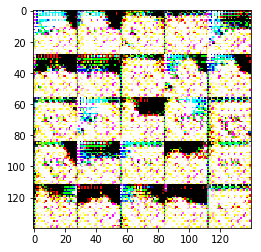

Epoch 1/1... Discriminator Loss: 0.3587... Generator Loss: 5.5356
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 2.7235
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 4.6213
Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 3.9672
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 4.7033
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 3.6262
Epoch 1/1... Discriminator Loss: 2.1619... Generator Loss: 6.5129
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 2.1680
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 4.1528
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.8436


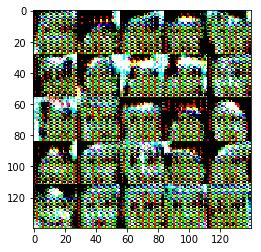

Epoch 1/1... Discriminator Loss: 2.3961... Generator Loss: 5.2394
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 3.0225
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 3.7026
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 2.4246
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 2.6308
Epoch 1/1... Discriminator Loss: 2.2842... Generator Loss: 5.7816
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 2.1741
Epoch 1/1... Discriminator Loss: 3.3358... Generator Loss: 5.3996
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 2.3426
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.0443


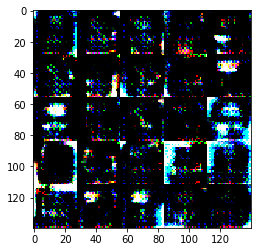

Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.7203
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 2.8966
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 2.6088
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.6678
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.5935
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 2.2598


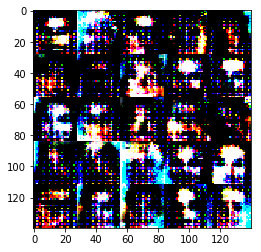

Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.8325
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.2526
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 2.0206
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.7888
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 2.4561
Epoch 1/1... Discriminator Loss: 2.2894... Generator Loss: 3.6681
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.4556


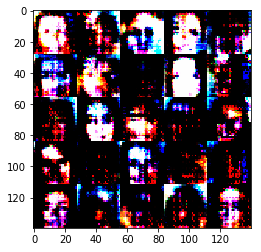

Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 3.2213
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 2.5385
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.2764
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.9184


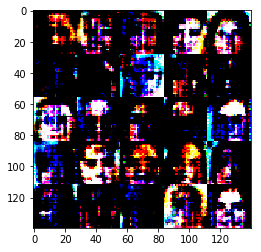

Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.6817
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.9403


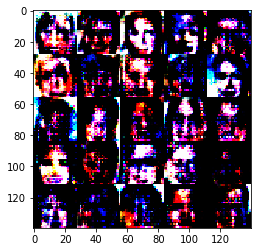

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 1.9686
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.6543
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.7373... Generator Loss: 2.8054
Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 2.5561
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 2.6469
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 1.0506


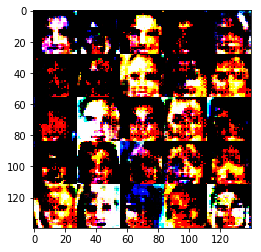

Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.3293
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9390


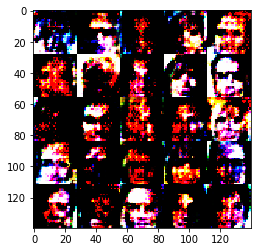

Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.2652


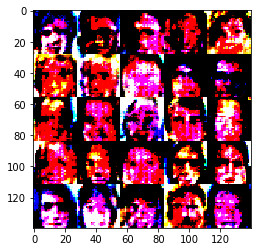

Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.4173


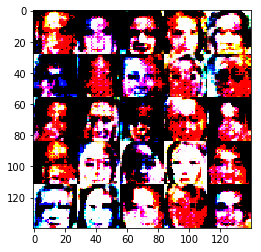

Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 1.5008
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.9968


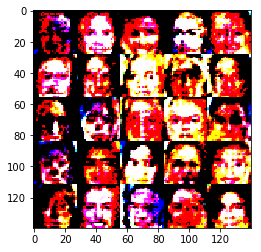

Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 1.0269


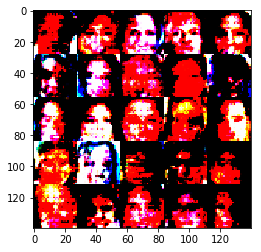

Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8231


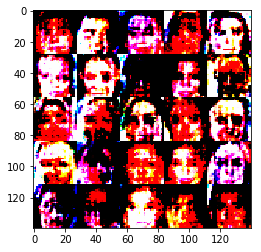

Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.9725


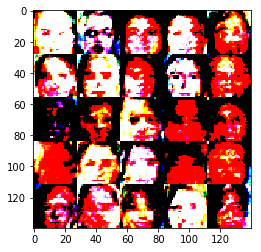

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 1.0649


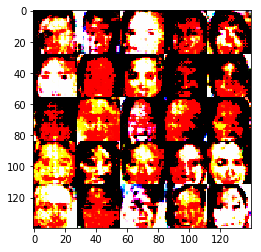

Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.2962


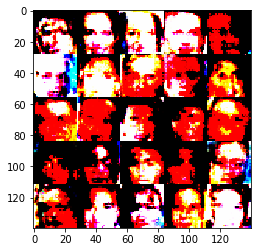

Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.0984


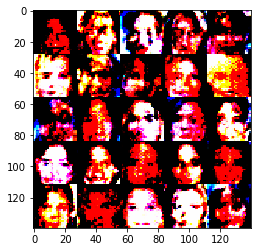

Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 1.7777
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.0428


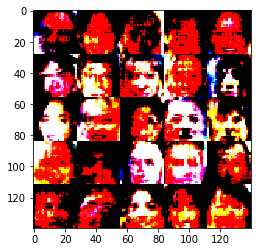

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.8807
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.2428
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.9381


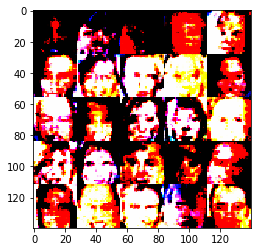

Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.9393


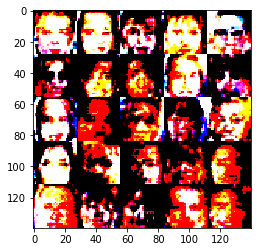

Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.0449


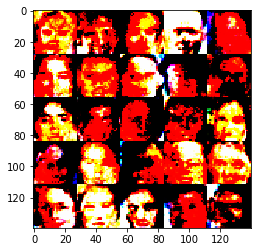

Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.5395


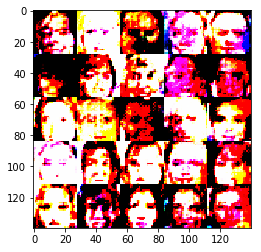

Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.8849
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8487


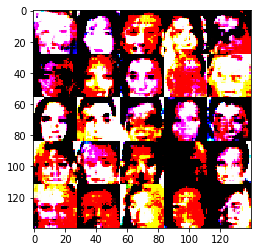

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8836


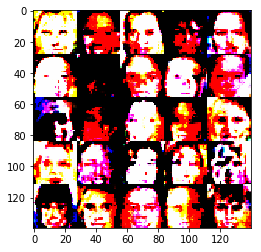

Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.9391


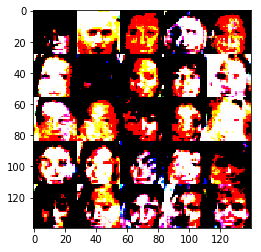

Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9085


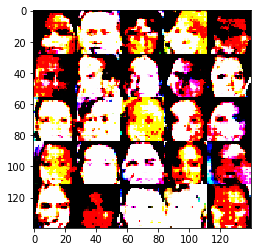

Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8349


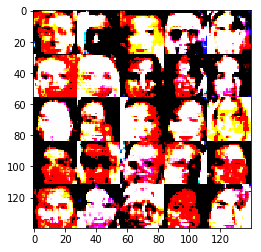

Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7518


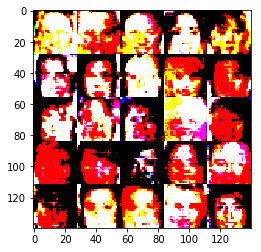

Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7648


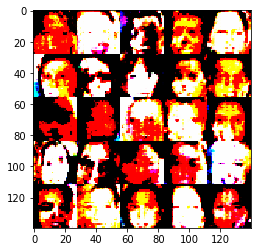

Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.9397


In [77]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.